### Credit Card Fraud Detection using AE

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project


---


source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
!pip install watermark
%load_ext watermark

In [2]:
# load the required libraries
import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable as V
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm, tqdm_notebook

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

In [4]:
from torch import optim


In [5]:
random_st = 1234

In [6]:
%watermark --iversions

seaborn   : 0.11.2
pandas    : 1.1.5
torch     : 1.9.0+cu111
numpy     : 1.19.5
IPython   : 5.5.0
sklearn   : 0.0
matplotlib: 3.2.2



data file
https://drive.google.com/file/d/1bqW2CBsT3BUAPX9PAhd2DIoA29n8_M99/view?usp=sharing

In [7]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
link = "https://drive.google.com/file/d/1bqW2CBsT3BUAPX9PAhd2DIoA29n8_M99/view?usp=sharing"
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# what isthe structure of my dataset
print(df.shape)
df.describe()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
df.agg(
    {
        "Time": ["min", "max", "median", "skew"],
         "Amount": ["min", "max", "median", "skew"],
     "Class": ["value_counts"],
    }
)

,Time,Amount,Class
,Time,Amount,value_counts
0,NaN,NaN,284315.0
1,NaN,NaN,492.0
max,172792.000000,25691.160000,NaN
median,84692.000000,22.000000,NaN
min,0.000000,0.000000,NaN
skew,-0.035568,16.977724,NaN


In [11]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [12]:
# # if null values are present
# # listwise removal
# print(df.shape)
# df_nomiss = df.dropna()
# df_nomiss.shape

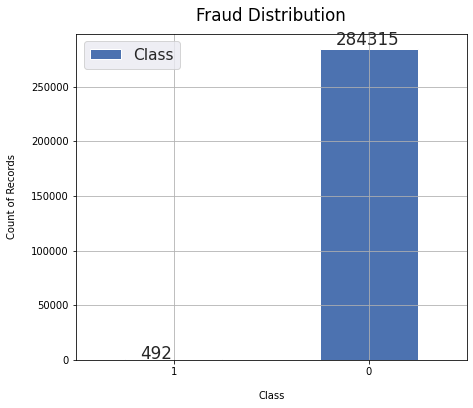

In [13]:
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
df.Class.value_counts(ascending=True).plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Class", labelpad=14)
plt.ylabel("Count of Records", labelpad=14)
plt.title("Fraud Distribution", y=1.02);

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() +.08, p.get_height() * 1.015))

plt.legend()

plt.show()

Closer look at fraudulent and non-fradulent transactions

In [14]:
# grouped summary
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


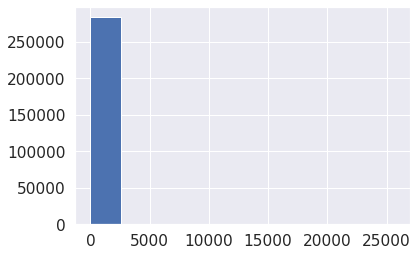

In [15]:
df[df.Class ==0].Amount.hist(bins= 10)

plt.show()

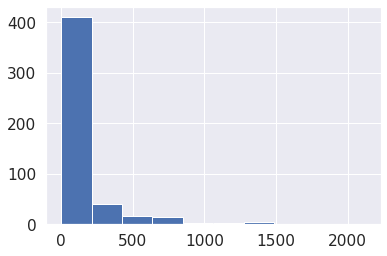

In [16]:
df[df.Class ==1].Amount.hist(bins= 10)

plt.show()

In [17]:
# what about the time variable
# it is given in seconds so convert it in hour of day
df['Hr'] = df.Time.apply(lambda x: np.ceil(float(x)/3600) % 24.0)
df.Hr.describe()

count    284807.000000
mean         14.124593
std           6.230831
min           0.000000
25%          10.000000
50%          15.000000
75%          19.000000
max          23.000000
Name: Hr, dtype: float64

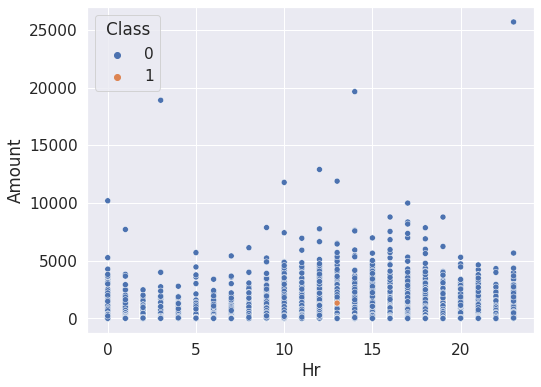

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='Hr', y='Amount', hue = 'Class', data=df) 
plt.show() 
# not clear what is going on...Let's split the data and examine again

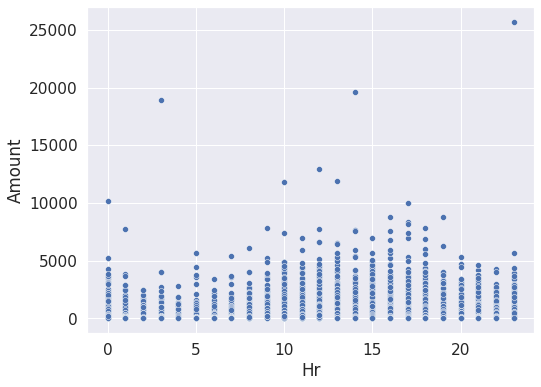

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='Hr', y='Amount', data=df[df.Class==0]) 
plt.show()

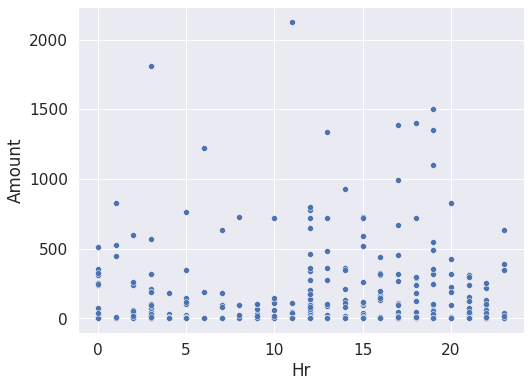

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='Hr', y='Amount', data=df[df.Class==1]) 
plt.show() # no pattern in fradulent amounts by time

Notes:
1. we will not use the time variable as such but you may try to use it and see if there is any improvement in the model
2. to teach a ANN (AE) we will use the normalised data
3. only the correct records will be used for training 
4. fraudulent records will be used later to see how the scoring comes out

In [21]:
#  df[df.Class == 0].dtypes

Data Preparation for Model Building

In [22]:
# remove time and keep records only from Class 0

df = df.drop(['Time', 'Hr'], axis = 1)
df.shape

(284807, 30)

In [23]:
# Amount variable needs to be rescaled before used in NN
y_vals = df['Class'].values
# df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
# df['Class'] = y_vals
df.Amount = StandardScaler().fit_transform(df.Amount.values.reshape(-1, 1))

In [24]:
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [25]:
# train test split for further processing with pytorch

train, test = train_test_split(df, train_size = 0.8, random_state = random_st)

# need to train VAE with only non-fraudulent transactions
train_nonfraud = train[train.Class == 0]
train_nonfraud = train_nonfraud.drop(['Class'], axis =1)
train_nonfraud = train_nonfraud.values
print(train_nonfraud.shape)

# test can remain as it is
# a mix of both fraud and non-fraud
y_test = test['Class'].values
x_test = test.drop('Class', axis =1).values
print(x_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [26]:
# using autoencoder model as feature selection method
# encoder= torch.load("./CC_fraud.pth")

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# change to torch tensors
train_nonfraud = torch.FloatTensor(train_nonfraud).to(device)

x_test = torch.FloatTensor(x_test).to(device)

In [29]:
# hyperparams
epochs = 200
batch_size = 1000
lr = 1e-02

# hidden_dim = 400
# latent_dim = 20

In [30]:
# data loader for batch processing
# define the trainloader
train_load = DataLoader(dataset = train_nonfraud,
                        batch_size = batch_size )


# define the testloader
test_load = DataLoader(dataset = x_test, 
                       batch_size= batch_size)

In [31]:
# Variational AE class
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()# this means it is a subclass of nn.Module & is inheriting all the methods
    # layered architechure
    self.fc1 = nn.Linear(29, 20) # hidden layer
    self.fc2 = nn.Linear(20, 10) # latent space (z below)

    self.fc3 = nn.Linear(10, 20)
    self.fc4 = nn.Linear(20, 29)
    # initialize weights
    self.fc1.weight.data.uniform_(-2,2)
    self.fc2.weight.data.uniform_(-2,2)
    self.fc3.weight.data.uniform_(-2,2)
    self.fc4.weight.data.uniform_(-2,2)

    self.tanh = nn.Tanh()

  def encoder(self, x):
    h = self.tanh(self.fc1(x))
    z = self.tanh(self.fc2(h))
    return z

  def decoder(self, z):
    h = self.tanh(self.fc3(z))
      
    reconstructed = self.fc4(h)
    return reconstructed

  def forward(self, x):
    z = self.encoder(x)
    reconstructed = self.decoder(z)
    return reconstructed

In [32]:
# optimize
model = VAE().to(device) 
optimizer = torch.optim.Adam(model.parameters(),  lr = lr)
# scheduler = lr_scheduler.StepLR(optimizer= optimizer, step_size=30, gamma=0.1 )

In [33]:
model.parameters

<bound method Module.parameters of VAE(
  (fc1): Linear(in_features=29, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=29, bias=True)
  (tanh): Tanh()
)>

In [34]:
next(model.parameters()).is_cuda

True

In [35]:
# loss

loss = nn.MSELoss()

In [36]:
def score(x):
  y_pred = model(x)
  return loss(y_pred,x).item()

In [37]:
# keeping track of the losses
# Utilize a named tuple to keep track of scores at each epoch
import collections
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

In [38]:
device

device(type='cuda')

In [39]:
# Train function
def train(epochs, model, loss):
  model.train()
  c = 0
  for epoch in tqdm_notebook(range(epochs), position =0, total = epochs):
    losses = []
    for i, data in enumerate(train_load):
      # forward
      data = data.to(device)
      reconstructed = model(data)
      ls = loss(reconstructed, data)
      losses.append(ls)
      #backward
      optimizer.zero_grad()
      ls.backward()
      optimizer.step()# adjust weights
    # scheduler.step()

    val_dl = iter(test_load)
    val_scores = [score(next(val_dl)) for i in range(len(val_dl))]

    #keep log of errors
    model_loss.epoch.append(c+epoch)
    model_loss.loss.append(ls.item())
    model_loss.val_loss.append(np.mean(val_scores))
    texts = ["Epoch: ","Loss: ","Val Loss: "]
    vals = [epoch, ls.item(), np.mean(val_scores)]
    print(" ".join([f'{x}{y:g}\t' for x,y in zip(texts, vals)]))

In [40]:
train(epochs=epochs, model = model, loss = loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0	 Loss: 1.02077	 Val Loss: 1.08358	
Epoch: 1	 Loss: 0.917349	 Val Loss: 0.998119	
Epoch: 2	 Loss: 0.870879	 Val Loss: 0.956691	
Epoch: 3	 Loss: 0.825376	 Val Loss: 0.907984	
Epoch: 4	 Loss: 0.787996	 Val Loss: 0.860077	
Epoch: 5	 Loss: 0.751437	 Val Loss: 0.819203	
Epoch: 6	 Loss: 0.711332	 Val Loss: 0.784371	
Epoch: 7	 Loss: 0.667542	 Val Loss: 0.751966	
Epoch: 8	 Loss: 0.641576	 Val Loss: 0.721919	
Epoch: 9	 Loss: 0.615008	 Val Loss: 0.689878	
Epoch: 10	 Loss: 0.584207	 Val Loss: 0.655394	
Epoch: 11	 Loss: 0.554475	 Val Loss: 0.622176	
Epoch: 12	 Loss: 0.518737	 Val Loss: 0.587601	
Epoch: 13	 Loss: 0.501403	 Val Loss: 0.561601	
Epoch: 14	 Loss: 0.472856	 Val Loss: 0.544571	
Epoch: 15	 Loss: 0.461442	 Val Loss: 0.531534	
Epoch: 16	 Loss: 0.445703	 Val Loss: 0.5201	
Epoch: 17	 Loss: 0.430292	 Val Loss: 0.508328	
Epoch: 18	 Loss: 0.420797	 Val Loss: 0.496086	
Epoch: 19	 Loss: 0.400488	 Val Loss: 0.478942	
Epoch: 20	 Loss: 0.386122	 Val Loss: 0.460577	
Epoch: 21	 Loss: 0.373451	 

In [41]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([20, 29])
fc1.bias 	 torch.Size([20])
fc2.weight 	 torch.Size([10, 20])
fc2.bias 	 torch.Size([10])
fc3.weight 	 torch.Size([20, 10])
fc3.bias 	 torch.Size([20])
fc4.weight 	 torch.Size([29, 20])
fc4.bias 	 torch.Size([29])


In [42]:
# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [43]:
torch.save(model, "./CC_model.pt")# saving whole model and not just state dict

In [44]:
!pip install -q bokeh==2.3.0

In [45]:
# Plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter
from bokeh.io import export_svgs
from bokeh.embed import components

import warnings
warnings.filterwarnings(action='ignore')
import bokeh.plotting

In [46]:
output_notebook()

In [47]:
def format_plot(p, x_label, y_label):
    p.grid.grid_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.outline_line_color = None
    p.axis.minor_tick_line_color = None
    p.title.align = "center"
    p.title.text_font_size = "22px"
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label_text_font_size = "18px"
    p.yaxis.axis_label_text_font_size = "18px"
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "14px"
    p.title.text_font = "helvetica"
    p.xaxis.axis_label_text_font = "helvetica"
    p.yaxis.axis_label_text_font = "helvetica"
    p.axis.major_label_text_font = "helvetica"
    return p

In [48]:
# Define a plot source
source = ColumnDataSource(data=dict(
    x=model_loss.epoch,
    loss=model_loss.loss,
    val_loss = model_loss.val_loss
))

p = bokeh.plotting.figure(plot_height = 500, 
           plot_width = 900,
           toolbar_location = None, 
           title = "Model L1 Loss")

ml = p.line(x = "x", y = "loss", 
           color=Set3_12[4], 
           line_width = 3, 
            
           legend = "Training Loss", 
           source=source)

p.line(x = "x", y = "val_loss", 
       color=Set3_12[5], 
       line_width = 3, 
       legend = "Validation Loss",
       source=source)


tips = [
    ("Epoch","@x"),
    ("Model Loss","@loss{0.000}"),
    ("Val Loss","@val_loss{0.000}")
]
p.add_tools(HoverTool(tooltips=tips, 
                      renderers= [ml], 
                      mode='vline'))


p = format_plot(p, 'Epoch', 'Loss')

bokeh.plotting.show(p)

In [49]:
print(df.shape)
X = df.drop(['Class'], axis =1).values
Y = df['Class'].values
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_st)


# encode the test data which has both fraud and non-frauds

# encoder_func = model.cpu() # use this if model is not saved
encoder_func = torch.load('./CC_model.pt').cpu()
encoder_func.eval()

X_train_encode = encoder_func(torch.FloatTensor(X_train)).data.numpy()
print(X_train_encode.shape)
# encode the test data
X_test_encode = encoder_func(torch.FloatTensor(X_test)).data.numpy()
print(X_test_encode.shape)

(284807, 30)
(227845, 29)
(56962, 29)


In [50]:
# define the model
mdl = LogisticRegression()
# fit the model on the training set
mdl.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = mdl.predict(X_test_encode)

In [51]:
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

cnf_matrix = confusion_matrix(y_test, yhat)
cnf_matrix

0.9992626663389628


array([[56847,    17],
       [   25,    73]])

In [52]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.74      0.78        98

    accuracy                           1.00     56962
   macro avg       0.91      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, yhat))
print("Precision:",metrics.precision_score(y_test, yhat))
print("Recall:",metrics.recall_score(y_test, yhat))

# Accuracy: 0.9991924440855307
# Precision: 0.776595744680851
# Recall: 0.7448979591836735

Accuracy: 0.9992626663389628
Precision: 0.8111111111111111
Recall: 0.7448979591836735


### Activity
Try the following changes to the model and re-run


1.   Use ReLU activation instead of tanh
2.   Use weight decay in the optimizer. You can set it to something very low such as 4e-03
3. Vary the batch size to see if any improvements can be achieved (e.g. from 1000 to 5000 or less than 500)
3. See if removing the amount variable has any impact on the overall model

